# Dog vs Cat Classification

### Importing the required libraries

In [1]:
import os, shutil, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mb_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import json
sns.set(style="whitegrid")



2025-11-02 09:24:45.762541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762075486.155276      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762075486.313211      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.__version__)

2.18.0


### Configuration

In [3]:
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
LIMIT_PER_CLASS = None  ## For testing before complete run
EPOCHS_CUSTOM = 50
EPOCHS_TL_INIT = 50
EPOCHS_TL_FINE = 50
FINE_TUNE_LAST_N = 20 
INPUT_DIR = "/kaggle/input/dog-vs-cat"
DATA_DIR = "/kaggle/working/data"

os.makedirs(DATA_DIR, exist_ok=True)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data loading and labelling

In [4]:
files = sorted(glob(os.path.join(INPUT_DIR, "train", "*.jpg")))
print("Raw files found:", len(files))

pairs = []
for f in files:
    fname = os.path.basename(f).lower()
    if "cat" in fname:
        pairs.append((f, "cat"))
    elif "dog" in fname:
        pairs.append((f, "dog"))

if LIMIT_PER_CLASS:
    cats = [p for p in pairs if p[1] == "cat"][:LIMIT_PER_CLASS]
    dogs = [p for p in pairs if p[1] == "dog"][:LIMIT_PER_CLASS]
    pairs = cats + dogs
    print(f"LIMIT_PER_CLASS used: {LIMIT_PER_CLASS} per class -> total {len(pairs)}")

labels = [p[1] for p in pairs]
print("Total images used:", len(pairs))


Raw files found: 25000
Total images used: 25000


### Data splitting

In [5]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, stratify=labels, random_state=SEED)
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.125, stratify=[p[1] for p in train_pairs], random_state=SEED)

for split in ["train", "val", "test"]:
    for cls in ["cat", "dog"]:
        os.makedirs(os.path.join(DATA_DIR, split, cls), exist_ok=True)

def copy_pairs(p_list, split):
    for src, cls in p_list:
        dst = os.path.join(DATA_DIR, split, cls, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs, "val")
copy_pairs(test_pairs, "test")
print("Data prepared at:", DATA_DIR)


Data prepared at: /kaggle/working/data


### Checking class balance

In [6]:
num_cats = sum(1 for _,lbl in pairs if lbl=='cat')
num_dogs = sum(1 for _,lbl in pairs if lbl=='dog')
print(f"Cats: {num_cats}, Dogs: {num_dogs}")

Cats: 12500, Dogs: 12500


### Displaying random images from the dataset

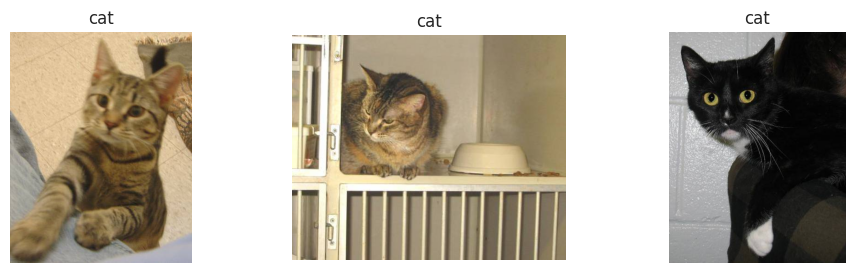

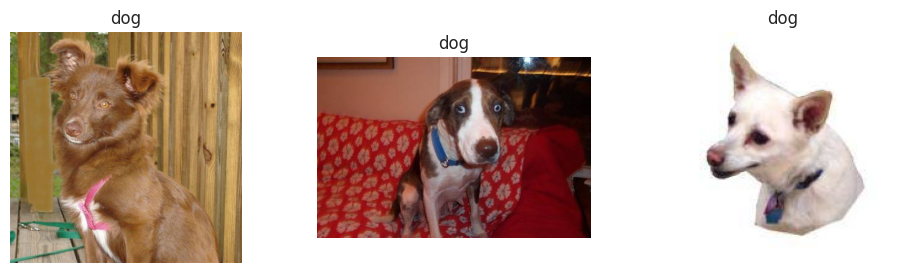

In [7]:
def show_random(class_name, n=3):
    class_files = [p[0] for p in pairs if p[1]==class_name]
    sampled = random.sample(class_files, min(n, len(class_files)))
    plt.figure(figsize=(12,3))
    for i,f in enumerate(sampled):
        img = Image.open(f)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_random("cat")
show_random("dog")


### Data preparation

In [8]:
def create_generators_for_custom(rescale=1./255):
    train_datagen = ImageDataGenerator(rescale=rescale,
                                       rotation_range=20, width_shift_range=0.15,
                                       height_shift_range=0.15, shear_range=0.12,
                                       zoom_range=0.15, horizontal_flip=True, fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=rescale)
    train_gen = train_datagen.flow_from_directory(os.path.join(DATA_DIR,"train"),
                                                  target_size=(IMG_SIZE,IMG_SIZE),
                                                  batch_size=BATCH_SIZE, class_mode='binary',
                                                  shuffle=True, seed=SEED)
    val_gen = val_datagen.flow_from_directory(os.path.join(DATA_DIR,"val"),
                                              target_size=(IMG_SIZE,IMG_SIZE),
                                              batch_size=BATCH_SIZE, class_mode='binary',
                                              shuffle=False)
    test_gen = val_datagen.flow_from_directory(os.path.join(DATA_DIR,"test"),
                                               target_size=(IMG_SIZE,IMG_SIZE),
                                               batch_size=BATCH_SIZE, class_mode='binary',
                                               shuffle=False)
    return train_gen, val_gen, test_gen

def create_generators_for_tl(preprocess_fn):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn,
                                       rotation_range=20, width_shift_range=0.15,
                                       height_shift_range=0.15, shear_range=0.12,
                                       zoom_range=0.15, horizontal_flip=True, fill_mode='nearest')
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    train_gen = train_datagen.flow_from_directory(os.path.join(DATA_DIR,"train"),
                                                  target_size=(IMG_SIZE,IMG_SIZE),
                                                  batch_size=BATCH_SIZE, class_mode='binary',
                                                  shuffle=True, seed=SEED)
    val_gen = val_datagen.flow_from_directory(os.path.join(DATA_DIR,"val"),
                                              target_size=(IMG_SIZE,IMG_SIZE),
                                              batch_size=BATCH_SIZE, class_mode='binary',
                                              shuffle=False)
    test_gen = val_datagen.flow_from_directory(os.path.join(DATA_DIR,"test"),
                                               target_size=(IMG_SIZE,IMG_SIZE),
                                               batch_size=BATCH_SIZE, class_mode='binary',
                                               shuffle=False)
    return train_gen, val_gen, test_gen

train_gen_custom, val_gen_custom, test_gen_custom = create_generators_for_custom()
train_gen_mb, val_gen_mb, test_gen_mb = create_generators_for_tl(mb_preprocess)
train_gen_eff, val_gen_eff, test_gen_eff = create_generators_for_tl(eff_preprocess)


Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Defining callbacks

In [9]:
def get_callbacks(name, monitor='val_auc'):
    weights_filepath = f"best_{name}.weights.h5"   # must end with '.weights.h5'
    es = EarlyStopping(monitor=monitor, patience=5, restore_best_weights=True, verbose=1, mode='max')
    rlr = ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=3, min_lr=1e-6, verbose=1, mode='max')
    ckpt = ModelCheckpoint(weights_filepath, monitor=monitor, save_best_only=True, save_weights_only=True, mode='max', verbose=1)
    return [es, rlr, ckpt]


### Building CNN models

In [10]:
def build_custom_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    model = models.Sequential([
        layers.Conv2D(16,3,padding='same',activation='relu',input_shape=input_shape,kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(16,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(), layers.Dropout(0.2),

        layers.Conv2D(32,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(32,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(), layers.Dropout(0.3),

        layers.Conv2D(64,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(64,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(), layers.Dropout(0.3),

        layers.Conv2D(128,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(128,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(), layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256,activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def build_mobilenetv2(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs, name="MobileNetV2_Classifier")
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model, base

def build_efficientnetb0(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs, name="EfficientNetB0_Classifier")
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model, base


### Training the models

In [11]:
from sklearn.metrics import roc_auc_score

def train_one(build_fn, name, train_gen, val_gen, test_gen,
              epochs_init, epochs_fine=None, fine_tune_layers=FINE_TUNE_LAST_N):

    ret = build_fn()
    if isinstance(ret, tuple) and len(ret)==2:
        model, base = ret
    else:
        model = ret
        base = None

    callbacks = get_callbacks(name)

    # initial training
    hist_init = model.fit(train_gen, validation_data=val_gen,
                          epochs=epochs_init, callbacks=callbacks,
                          steps_per_epoch=len(train_gen),
                          validation_steps=len(val_gen))
    hist = hist_init

    # fine-tuneing for pretrained models
    if epochs_fine and base is not None:
        print(f"[{name}] Fine-tuning: unfreezing last {fine_tune_layers} layers...")
        base.trainable = True
        total = len(base.layers)
        freeze_until = max(0, total - fine_tune_layers)
        for i, layer in enumerate(base.layers):
            layer.trainable = False if i < freeze_until else True

        model.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        hist_fine = model.fit(train_gen, validation_data=val_gen,
                              epochs=epochs_fine, callbacks=callbacks,
                              steps_per_epoch=len(train_gen),
                              validation_steps=len(val_gen))

        # merge histories
        combined = {}
        for k in set(list(hist_init.history.keys()) + list(hist_fine.history.keys())):
            combined[k] = hist_init.history.get(k, []) + hist_fine.history.get(k, [])
        class SimpleHistory: 
            def __init__(self, h): self.history = h
        hist = SimpleHistory(combined)
    elif epochs_fine and base is None:
        print(f"[{name}] Fine-tune requested but no base model; skipping.")

    # evaluatinf the models
    preds = model.predict(test_gen, verbose=0)
    y_prob = preds.reshape(-1)
    y_pred = (y_prob > 0.5).astype(int)
    y_true = test_gen.classes
    acc = np.mean(y_pred == y_true)
    auc = roc_auc_score(y_true, y_prob)

    return model, hist, acc, auc, y_pred, y_true


### Custom CNN

In [12]:
tf.keras.backend.clear_session()
custom_model, h_custom, acc_custom, auc_custom, pred_custom, true_custom = train_one(
    build_custom_cnn, "custom", train_gen_custom, val_gen_custom, test_gen_custom,
    epochs_init=EPOCHS_CUSTOM, epochs_fine=None
)
print("Custom CNN -> Acc: %.4f, AUC: %.4f" % (acc_custom, auc_custom))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762075769.291334      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762075769.292045      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can i

Epoch 1/50


I0000 00:00:1762075781.713594     128 service.cc:148] XLA service 0x7ca7fc002350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762075781.715097     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762075781.715123     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762075782.778345     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/547 ━━━━━━━━━━━━━━━━━━━━ 3:45:24 25s/step - accuracy: 0.4062 - auc: 0.4434 - loss: 1.2189

I0000 00:00:1762075796.505947     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5921 - auc: 0.6261 - loss: 0.8803
Epoch 1: val_auc improved from -inf to 0.73688, saving model to best_custom.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 225s 366ms/step - accuracy: 0.5921 - auc: 0.6262 - loss: 0.8802 - val_accuracy: 0.6468 - val_auc: 0.7369 - val_loss: 0.7457 - learning_rate: 0.0010
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6952 - auc: 0.7660 - loss: 0.7164
Epoch 2: val_auc improved from 0.73688 to 0.85393, saving model to best_custom.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 187s 342ms/step - accuracy: 0.6953 - auc: 0.7660 - loss: 0.7164 - val_accuracy: 0.7640 - val_auc: 0.8539 - val_loss: 0.6102 - learning_rate: 0.0010
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7443 - auc: 0.8206 - loss: 0.6495
Epoch 3: val_auc improved from 0.85393 to 0.87674, saving model to best_custom.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 183s 335ms/step - accuracy: 0.7443 - auc: 0.8206 - loss

### Mobilenet

In [13]:
tf.keras.backend.clear_session()
mb_model, h_mb, acc_mb, auc_mb, pred_mb, true_mb = train_one(
    build_mobilenetv2, "mobilenet", train_gen_mb, val_gen_mb, test_gen_mb,
    epochs_init=EPOCHS_TL_INIT, epochs_fine=EPOCHS_TL_FINE, fine_tune_layers=FINE_TUNE_LAST_N
)
print("MobileNetV2 -> Acc: %.4f, AUC: %.4f" % (acc_mb, auc_mb))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9326 - auc: 0.9776 - loss: 0.1651
Epoch 1: val_auc improved from -inf to 0.99861, saving model to best_mobilenet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 208s 361ms/step - accuracy: 0.9327 - auc: 0.9776 - loss: 0.1650 - val_accuracy: 0.9800 - val_auc: 0.9986 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9763 - auc: 0.9973 - loss: 0.0617
Epoch 2: val_auc improved from 0.99861 to 0.99883, saving model to best_mobilenet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 184s 336ms/step - accuracy: 0.9763 - auc: 0.9973 - loss: 0.0617 - val_accuracy: 0.9824 - val_auc: 0.9988 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9817 - auc: 0.9981 - loss: 0.0505
Epoch 3: val_auc improved from 0.99883 to 0.99925, saving model to best_mobilenet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 186s 339ms/step - accuracy: 0.9817 

### Efficientnet

In [14]:
tf.keras.backend.clear_session()
eff_model, h_eff, acc_eff, auc_eff, pred_eff, true_eff = train_one(
    build_efficientnetb0, "efficientnet", train_gen_eff, val_gen_eff, test_gen_eff,
    epochs_init=EPOCHS_TL_INIT, epochs_fine=EPOCHS_TL_FINE, fine_tune_layers=FINE_TUNE_LAST_N
)
print("EfficientNetB0 -> Acc: %.4f, AUC: %.4f" % (acc_eff, auc_eff))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9398 - auc: 0.9809 - loss: 0.1778
Epoch 1: val_auc improved from -inf to 0.99956, saving model to best_efficientnet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 221s 362ms/step - accuracy: 0.9398 - auc: 0.9809 - loss: 0.1776 - val_accuracy: 0.9900 - val_auc: 0.9996 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9859 - auc: 0.9984 - loss: 0.0457
Epoch 2: val_auc improved from 0.99956 to 0.99972, saving model to best_efficientnet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 179s 327ms/step - accuracy: 0.9859 - auc: 0.9984 - loss: 0.0457 - val_accuracy: 0.9912 - val_auc: 0.9997 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9866 - auc: 0.9986 - loss: 0.0407
Epoch 3: val_auc improved from 0.99972 to 0.99973, saving model to best_efficientnet.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 182s 332ms/step - accuracy

### Plotting the training curves

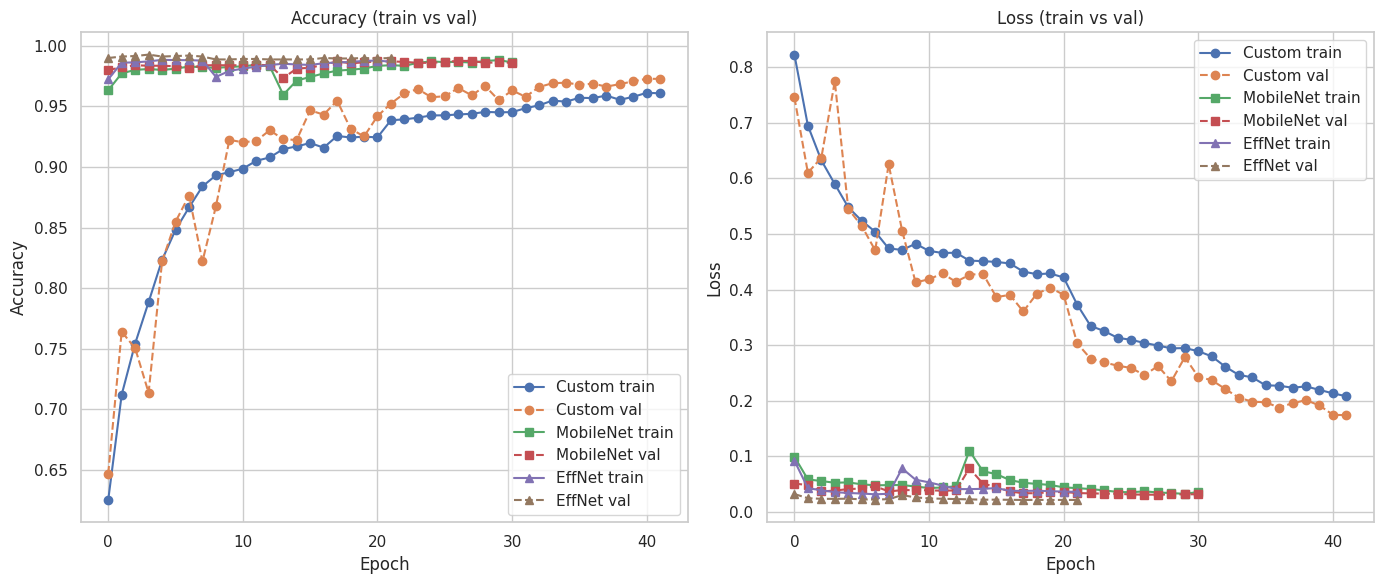

In [15]:
def hist_to_dict(h):
    if h is None: 
        return {}
    if hasattr(h, "history"): 
        return h.history
    if isinstance(h, dict): 
        return h
    return getattr(h, "history", {})

hc = hist_to_dict(h_custom)
hm = hist_to_dict(h_mb) 
he = hist_to_dict(h_eff)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
if 'accuracy' in hc: 
    plt.plot(hc['accuracy'], label='Custom train', marker='o')
if 'val_accuracy' in hc: 
    plt.plot(hc['val_accuracy'], label='Custom val', linestyle='--', marker='o')
if 'accuracy' in hm: 
    plt.plot(hm['accuracy'], label='MobileNet train', marker='s')
if 'val_accuracy' in hm: 
    plt.plot(hm['val_accuracy'], label='MobileNet val', linestyle='--', marker='s')
if 'accuracy' in he: 
    plt.plot(he['accuracy'], label='EffNet train', marker='^')
if 'val_accuracy' in he: 
    plt.plot(he['val_accuracy'], label='EffNet val', linestyle='--', marker='^')
plt.title("Accuracy (train vs val)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.legend() 
plt.grid(True)

plt.subplot(1,2,2)
if 'loss' in hc: 
    plt.plot(hc['loss'], label='Custom train', marker='o')
if 'val_loss' in hc: 
    plt.plot(hc['val_loss'], label='Custom val', linestyle='--', marker='o')
if 'loss' in hm: 
    plt.plot(hm['loss'], label='MobileNet train', marker='s')
if 'val_loss' in hm: 
    plt.plot(hm['val_loss'], label='MobileNet val', linestyle='--', marker='s')
if 'loss' in he: 
    plt.plot(he['loss'], label='EffNet train', marker='^')
if 'val_loss' in he: 
    plt.plot(he['val_loss'], label='EffNet val', linestyle='--', marker='^')
plt.title("Loss (train vs val)") 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend() 
plt.grid(True)

plt.tight_layout()
plt.show()



=== Custom CNN ===
Accuracy: 0.9692 | AUC: 0.9961
              precision    recall  f1-score   support

         Cat       0.97      0.97      0.97      2500
         Dog       0.97      0.96      0.97      2500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



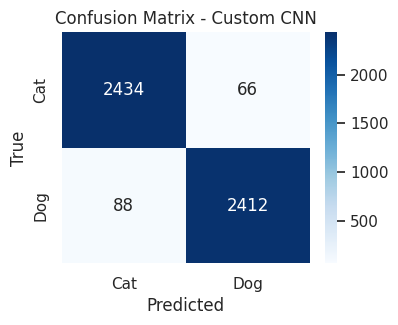


=== MobileNetV2 ===
Accuracy: 0.9874 | AUC: 0.9994
              precision    recall  f1-score   support

         Cat       0.99      0.98      0.99      2500
         Dog       0.98      0.99      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



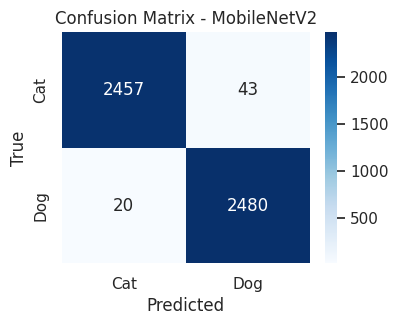


=== EfficientNetB0 ===
Accuracy: 0.9916 | AUC: 0.9997
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      2500
         Dog       0.99      0.99      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



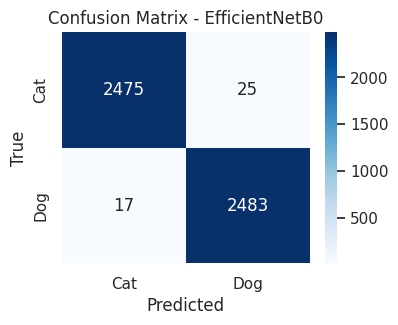

In [16]:
import seaborn as sns

def eval_model(model, test_gen, name):
    y_prob = model.predict(test_gen, verbose=0).reshape(-1)
    y_pred = (y_prob > 0.5).astype(int)
    y_true = test_gen.classes
    acc = np.mean(y_pred == y_true)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n=== {name} ===\nAccuracy: {acc:.4f} | AUC: {auc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['Cat','Dog']))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
    plt.title(f"Confusion Matrix - {name}"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    return acc, auc

acc_c2, auc_c2 = eval_model(custom_model, test_gen_custom, "Custom CNN")
acc_mb2, auc_mb2 = eval_model(mb_model, test_gen_mb, "MobileNetV2")
acc_eff2, auc_eff2 = eval_model(eff_model, test_gen_eff, "EfficientNetB0")


| Model          | Accuracy | AUC     |
|----------------|----------|---------|
| Custom CNN     | 0.9692   | 0.9961  |
| EfficientNetB0 | 0.9916   | 0.9997  |
| MobileNetV2    | 0.9874   | 0.9994  |



### Comparing the choosing the best model

In [17]:
models_info = {
    'custom': {'model': custom_model, 'acc': acc_c2, 'auc': auc_c2, 'test_gen': test_gen_custom},
    'mobilenet': {'model': mb_model, 'acc': acc_mb2, 'auc': auc_mb2, 'test_gen': test_gen_mb},
    'efficientnet': {'model': eff_model, 'acc': acc_eff2, 'auc': auc_eff2, 'test_gen': test_gen_eff}
}

sorted_models = sorted(models_info.items(), key=lambda kv: (kv[1]['acc'], kv[1]['auc']), reverse=True)
best_key, best_info = sorted_models[0]
best_model = best_info['model']
best_test_gen = best_info['test_gen']
print("Best model chosen:", best_key, f"(Acc={best_info['acc']:.4f}, AUC={best_info['auc']:.4f})")

# Saving the best model
best_full = "best_overall.keras"
best_weights = "best_overall.weights.h5"
meta = {"model_key": best_key, "img_size": IMG_SIZE}
try:
    best_model.save(best_full)
    print("Saved full best model to", best_full)
    best_model.save_weights(best_weights)
    print("Saved weights to", best_weights)
except Exception as e:
    print("Full save failed:", e, "Saving weights only.")
    best_model.save_weights(best_weights)

with open("best_overall.meta.json","w") as f:
    json.dump(meta, f)
print("Saved metadata to best_overall.meta.json:", meta)


Best model chosen: efficientnet (Acc=0.9916, AUC=0.9997)
Saved full best model to best_overall.keras
Saved weights to best_overall.weights.h5
Saved metadata to best_overall.meta.json: {'model_key': 'efficientnet', 'img_size': 224}


### Sample prediction

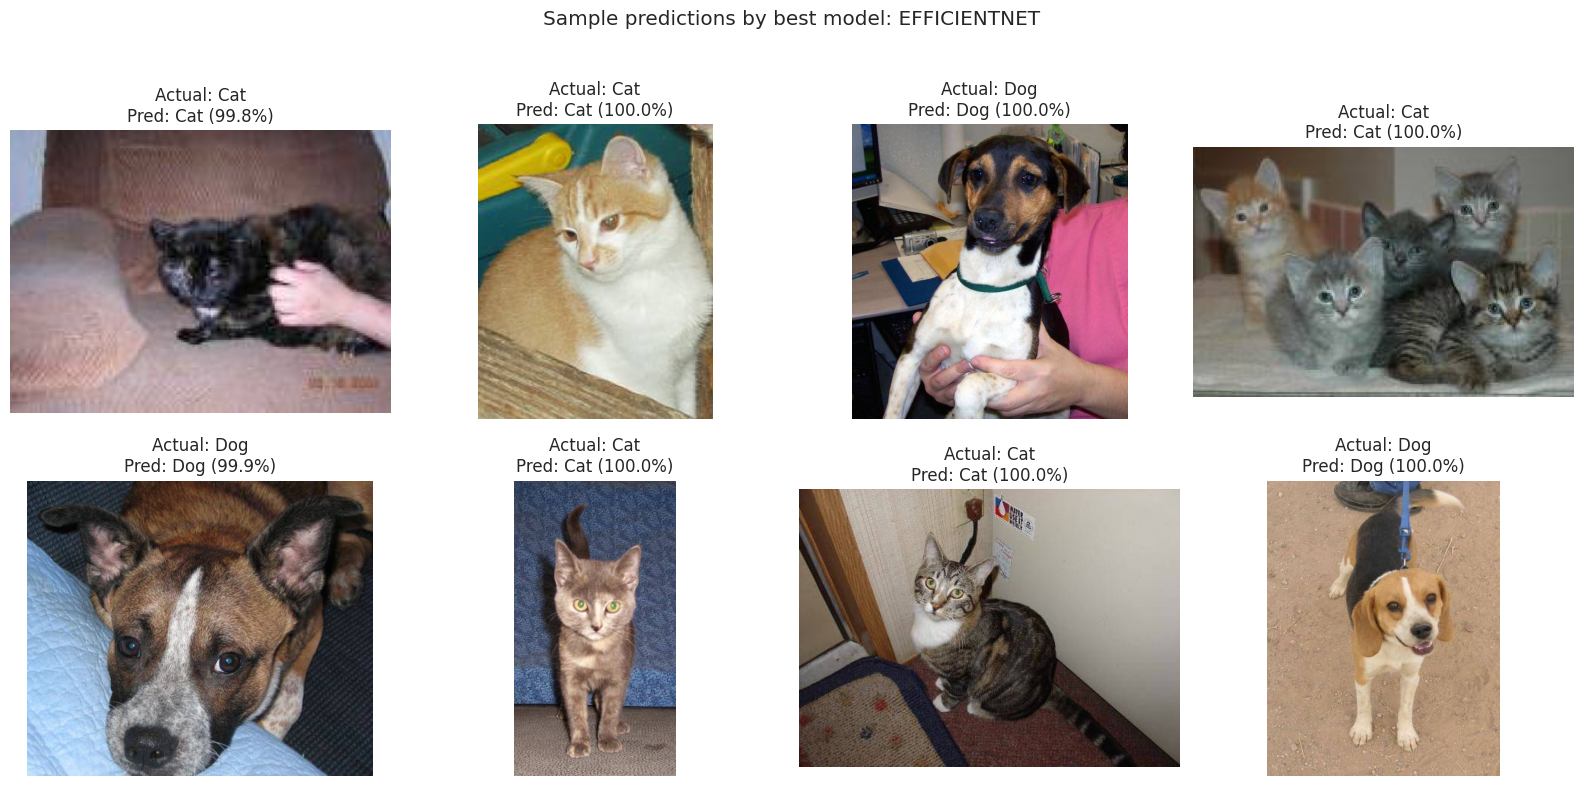

In [18]:
def preprocess_path(path, model_key):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE,IMG_SIZE))
    arr = np.array(img).astype(np.float32)
    arr = np.expand_dims(arr, axis=0)
    if model_key == 'mobilenet':
        return mb_preprocess(arr)
    elif model_key == 'efficientnet':
        return eff_preprocess(arr)
    else:
        return arr / 255.0

test_files = best_test_gen.filepaths
n = min(8, len(test_files))
indices = random.sample(range(len(test_files)), n)

plt.figure(figsize=(16,8))
for i, idx in enumerate(indices):
    fp = test_files[idx]
    actual = "Dog" if best_test_gen.classes[idx]==1 else "Cat"
    x = preprocess_path(fp, best_key)
    prob = float(best_model.predict(x, verbose=0).reshape(-1)[0])
    pred = "Dog" if prob>0.5 else "Cat"
    conf = prob if prob>0.5 else 1.0 - prob
    plt.subplot(2,4,i+1)
    plt.imshow(Image.open(fp))
    plt.title(f"Actual: {actual}\nPred: {pred} ({conf*100:.1f}%)")
    plt.axis('off')
plt.suptitle(f"Sample predictions by best model: {best_key.upper()}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
